# Finding stories in data with Python and Jupyter notebooks
[Journocoders London](https://www.meetup.com/Journocoders/), April 13, 2017  

David Blood/[@davidcblood](https://twitter.com/davidcblood)/[first] dot [last] at ft.com

## Introduction
The [Jupyter](http://jupyter.org/) notebook provides an intuitive, flexible and shareable way to work with code. It's a potentially invaluable tool for journalists who need to analyse data quickly and reproducibly, particularly as part of a graphics-oriented workflow.

This aim of this tutorial is to help you become familiar with the notebook and its role in a [Python](https://www.python.org/) data analysis toolkit. We'll start with a demographic dataset and explore and analyse it visually in the notebook to see what it can tell us about people who voted ‘leave’ in the UK's EU referendum. To finish, we'll output a production-quality graphic using [Bokeh](http://bokeh.pydata.org/en/latest/).

You'll need access to an empty Python 3 Jupyter notebook, ideally running on your local machine, although a cloud-based Jupyter environment is fine too.

You're ready to start the tutorial when you're looking at this screen:

![Empty Python 3 notebook](https://github.com/davidbjourno/finding-stories-in-data/raw/master/images/fsid-empty-notebook.png)

## 1. Bring your data into the notebook

In Python-world, people often use the [pandas](http://pandas.pydata.org/) module for working with data. You don't have to—there are other modules that do similar things—but it's the most well-known and comprehensive (probably).

Let's [import](https://docs.python.org/3/reference/import.html) pandas into our project and assign it to the variable `pd`, because that's easier to type than `pandas`. While we're at it, let's import all the other modules we'll need for this tutorial and also let [Matplotlib](http://matplotlib.org/) know that we want it to plot charts here in the notebook rather than in a separate window. Enter the following code into the first cell in your notebook and hit shift-return to run the code block:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from bokeh.plotting import figure, show
from bokeh.io import output_notebook

%matplotlib inline

There shouldn't be any output from that cell, but if you get any error messages, it's most likely because you don't have one or more of these modules installed on your system. Running
```
pip3 install pandas matplotlib numpy seaborn bokeh
```
from the command line should take care of that. If not, holler and I'll try to help you.

As well as running your code, hitting shift-return in that first cell should have automatically created an empty cell below it. In that cell, we're going to use the `read_csv` method provided by pandas to, um, read our CSV.

When pandas reads data from a CSV file, it automagically puts it into something called a _dataframe_. It's not important at this point to understand what a dataframe is or how it differs from other [Python data structures](https://docs.python.org/3/tutorial/datastructures.html?highlight=dictionary#data-structures). All you need to know for now is that it's an object containing structured data that's stored in memory for the duration of your notebook session.

We'll also assign our new dataframe to another variable—`df`—so we can do things with it down the line.

We do all of this in one go, like so (remember to hit shift-return):

In [2]:
# Pass in the URL of the CSV file:
df = pd.read_csv('https://raw.githubusercontent.com/davidbjourno/finding-stories-in-data/master/data/leave-demographics.csv')

See how easy that was? Now let's check that `df` is in fact a dataframe. Using the `.head(n=[number])` method on any dataframe will return the first `[number]` rows of that dataframe. Let's take a look at the first ten:

In [3]:
df.head(n=10)

,ons_id,name,region_name,electorate,result,leave,turnout,votes_cast,var1,var2,var3,var4,var5,var6,var7,var8,var9
0,E06000001,Hartlepool,North East,70341,leave,69.6,65.6,46134,48.8,23.9,49.5,15.9,17.6,495.2,30.5,25.6,13.0
1,E06000002,Middlesbrough,North East,94612,leave,65.5,64.9,61393,48.5,25.0,66.1,42.6,18.5,467.6,64.9,22.6,13.3
2,E06000003,Redcar and Cleveland,North East,103529,leave,66.2,70.3,72741,16.8,22.3,25.0,64.0,18.9,505.5,18.6,23.8,13.2
3,E06000004,Stockton-on-Tees,North East,141486,leave,61.7,71.0,100460,24.4,25.2,58.3,17.2,22.8,502.5,45.3,20.5,15.9
4,E06000005,Darlington,North East,77662,leave,56.2,71.1,55195,23.8,24.6,55.6,50.5,23.7,484.0,29.9,21.7,15.2
5,E06000006,Halton,North West,95289,leave,57.4,68.3,65047,19.9,25.4,30.2,47.7,17.6,484.7,46.1,21.0,11.9
6,E06000007,Warrington,North West,157042,leave,54.3,73.4,115205,4.6,26.0,35.4,27.5,27.4,545.6,33.7,15.5,18.1
7,E06000008,Blackburn with Darwen,North West,100117,leave,56.3,65.3,65408,21.2,26.8,6.5,31.8,19.8,413.0,51.6,18.2,14.0
8,E06000009,Blackpool,North West,102354,leave,67.5,65.4,66959,43.9,23.3,45.9,15.2,15.5,392.4,46.6,24.4,10.3
9,E06000010,Hull,Yorkshire and The Humber,180230,leave,67.6,62.9,113436,60.9,28.2,7.7,31.0,15.2,445.9,31.4,26.9,10.5


Looks good!

(`.tail(n=[number])` will give you the last `[number]` rows.)

By now, you may have noticed that some of the row headers in this CSV aren't particularly descriptive (`var1`, `var2` etc.). This is the game: **by the end of this tutorial, you should be able to identify the variables that correlated most strongly with the percentage of ‘leave’ votes (the `leave` column), i.e. which factors were the most predictive of people voting ‘leave’. At the end of the meetup, before we all go down the pub, you can tell me which variables you think correlated most strongly and I'll tell you what each of them are** 😁

## 2. Explore the data

The main advantage of the workflow we're using here is that it enables us to inspect a dataset visually, which can often be the quickest way to identify patterns, trends or outliers in data. A common first step in this process is to use scatter plots to visualise the relationship, if any, between two variables. So let's use Matplotlib to create a first, super basic [scatter plot](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.scatter):

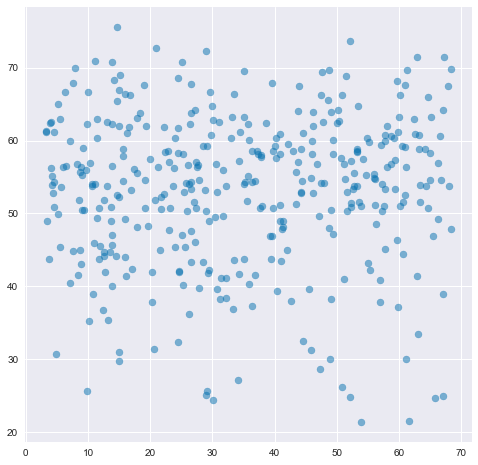

In [4]:
# Configure Matplotlib's pyplot method (plt) to plot at a size of 8x8 inches and
# a resolution of 72 dots per inch
plt.figure(
    figsize=(8, 8),
    dpi=72
)

# Plot the data as a scatter plot
g = plt.scatter(
    x=df['var1'], # The values we want to plot along the x axis
    y=df['leave'], # The values we want to plot along the y axis
    s=50, # The size…
    c='#0571b0', # …colour…
    alpha=0.5 # …and opacity we want the data point markers to be
)

Yikes, not much of a relationship there. Let's try a different variable:

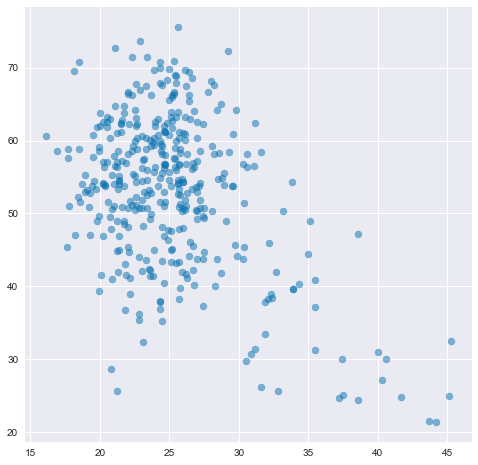

In [5]:
plt.figure(
    figsize=(8, 8),
    dpi=72
)

g = plt.scatter(
    x=df['var2'], # Plotting var2 along the x axis this time
    y=df['leave'],
    s=50,
    c='#0571b0',
    alpha=0.5
)

Hmm, that distribution looks better—there's a stronger, negative correlation there—but it's still a little unclear what we're looking at. Let's add some context.

We know from our provisional data-munging (that we didn't do) that many of the boroughs of London were among the strongest ‘remain’ areas in the country. We can add an additional column called `is_london` to our dataframe and set the values of that column to either `True` or `False` depending on whether the value in the row's `region_name` column is `London`:

In [6]:
df['is_london'] = np.where(df['region_name'] == 'London', True, False)

# Print all the rows in the dataframe in which is_london is equal to True
df[df['is_london'] == True]

,ons_id,name,region_name,electorate,result,leave,turnout,votes_cast,var1,var2,var3,var4,var5,var6,var7,var8,var9,is_london
293,E09000001,City of London,London,5987,remain,24.7,73.6,4405,65.7,37.2,37.4,25.2,68.4,864.7,27.6,3.2,39.9,True
294,E09000002,Barking and Dagenham,London,115812,leave,62.4,63.9,73941,38.6,31.2,34.5,18.2,20.9,534.5,43.2,16.0,13.3,True
295,E09000003,Barnet,London,223467,remain,37.8,72.1,161218,20.3,31.9,49.7,30.1,40.3,629.8,66.4,5.6,24.7,True
296,E09000004,Bexley,London,170779,leave,63.0,75.3,128570,5.5,26.5,29.8,56.1,21.8,612.7,31.6,12.3,14.7,True
297,E09000005,Brent,London,186793,remain,40.3,65.1,121671,35.8,34.3,50.3,12.9,33.3,551.4,30.8,5.1,18.2,True
298,E09000006,Bromley,London,231473,remain,49.4,78.9,182570,11.5,27.5,42.1,62.2,33.1,681.0,65.0,9.6,21.4,True
299,E09000007,Camden,London,145425,remain,25.1,65.5,95281,29.0,37.5,44.9,5.3,50.5,719.8,31.6,4.8,31.9,True
300,E09000008,Croydon,London,245349,remain,45.7,69.8,171289,13.8,29.7,37.7,12.2,31.8,602.8,12.4,10.4,19.6,True
301,E09000009,Ealing,London,212991,remain,39.6,70.1,149268,30.8,33.9,66.4,18.2,37.0,562.2,34.4,6.2,21.0,True
302,E09000010,Enfield,London,198387,remain,44.2,69.1,137056,14.5,29.9,47.3,68.2,28.7,564.0,10.6,8.6,19.0,True


Those names should look familiar. That's numpy's [`.where`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.where.html) method coming in handy there to help us generate a new column of data based on the values of another column—in this case, `region_name`.

At this point, we're going to abandon Matplotlib like merciless narcissists and turn our attention to the younger, hotter [Seaborn](https://seaborn.pydata.org/). Though it sounds like one of the factions from _Game of Thrones_, it's actually another plotting module that includes some handy analytical shortcuts and statistical methods. One of those analytical shortcuts is the [`FacetGrid`](http://seaborn.pydata.org/generated/seaborn.FacetGrid.html).

If you've ever used [OpenRefine](http://openrefine.org/), you're probably familiar with the concept of faceting. I'll fumblingly describe it here as a method whereby data is apportioned into distinct matrices according to the values of a single field. You get the idea. Right now, we're going to facet on the `is_london` column so that we can distinguish the London boroughs from the rest of the UK:

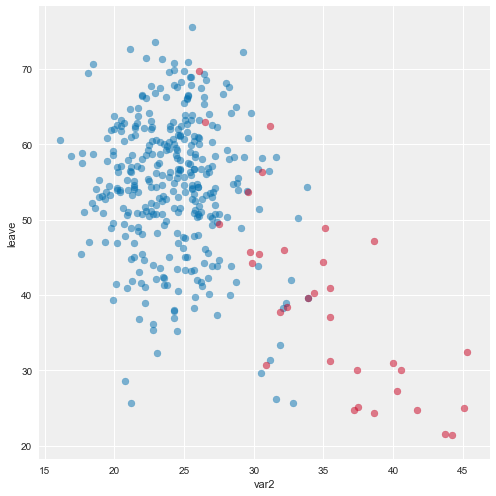

In [7]:
# Set the chart background colour (completely unnecessary, I just don't like the
# default)
sns.set_style('darkgrid', { 'axes.facecolor': '#efefef' })

# Tell Seaborn that what we want from it is a FacetGrid, and assign this to the
# variable ‘fg’
fg = sns.FacetGrid(
    data=df, # Use our dataframe as the input data
    hue='is_london', # Highlight the data points for which is_london == True
    palette=['#0571b0', '#ca0020'], # Define a tasteful blue/red colour combo
    size=7 # Make the plots size 7, whatever that means
)

# Tell Seaborn that what we want to do with our FacetGrid (fg) is visualise it
# as a scatter plot
fg.map(
    plt.scatter,
    'var2', # Values to plot along the x axis
    'leave', # Values to plot along the y axis
    alpha=0.5
)

Now we're cooking with gas! We can see a slight negative correlation in the distribution of the data points _and_ we can see how London compares to all the other regions of the country. Whatever `var2` is, we now know that the London boroughs generally have higher levels of it than most of the rest of the UK, and that it has a (weak) negative correlation with ‘leave’ vote percentage.

So what's to stop you faceting on `is_london` but with a different variable plotted along the x axis? The answer is: nothing! Try doing that exact thing right now:

In [8]:
# Plot the chart above with a different variable along the x axis.

What's more, faceting isn't limited to just highlighting specific data points. We can also pass `FacetGrid` a `col` (column) argument with the name of a column that we'd like to use to further segment our data. So let's create another `True`/`False` ([Boolean](https://en.wikipedia.org/wiki/Boolean_data_type)) column to flag the areas with the largest populations—the ones with electorates of 100,000 people or more—and plot a new facet grid:

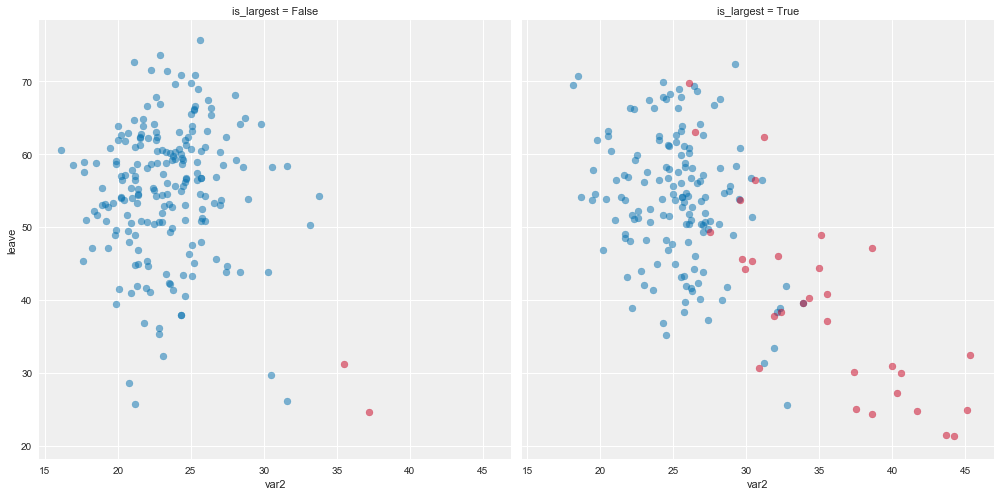

In [9]:
df['is_largest'] = np.where(df['electorate'] >= 100000, True, False)

g = sns.FacetGrid(
    df,
    hue='is_london', 
    col='is_largest',
    palette=['#0571b0', '#ca0020'],
    size=7
)

g.map(
    plt.scatter,
    'var2',
    'leave',
    alpha=0.5
)

Now we're able to make the following statements based solely on a visual inspection of this facet grid:

* Most of the less populous areas (electorate < 100,000) voted ‘leave’
* Most of the less populous areas had `var2` levels below 35. Only two—both London boroughs—had levels higher than 35
* There is a stronger correlation between the strength of the ‘leave’ vote and the level of `var2` among the more populous areas

So you see how faceting can come in handy when you come to a dataset cold and need to start to understand it quickly.

As yet, we still don't have much of a story, just a few observations—not exactly Pulitzer material. The next and most important step is to narrow down which of the variables in the dataset were the most indicative of ‘leave’ vote percentage. The good news is that we don't have to repeat the facet grid steps above for every variable, because Seaborn provides another useful analytical shortcut called a [`PairGrid`](https://seaborn.pydata.org/generated/seaborn.PairGrid.html#seaborn.PairGrid).

## 3. Optimise for efficiency

Apparently there's an equivalent to the pair grid in R called a correlogram or something (I wouldn't know). But the pair grid is super sweet because it allows us to check for correlations across a large number of variables at once. By passing the `PairGrid` function an array of column headers from our dataset, we can plot each of those variables against every other variable in one amazing ultra-grid:

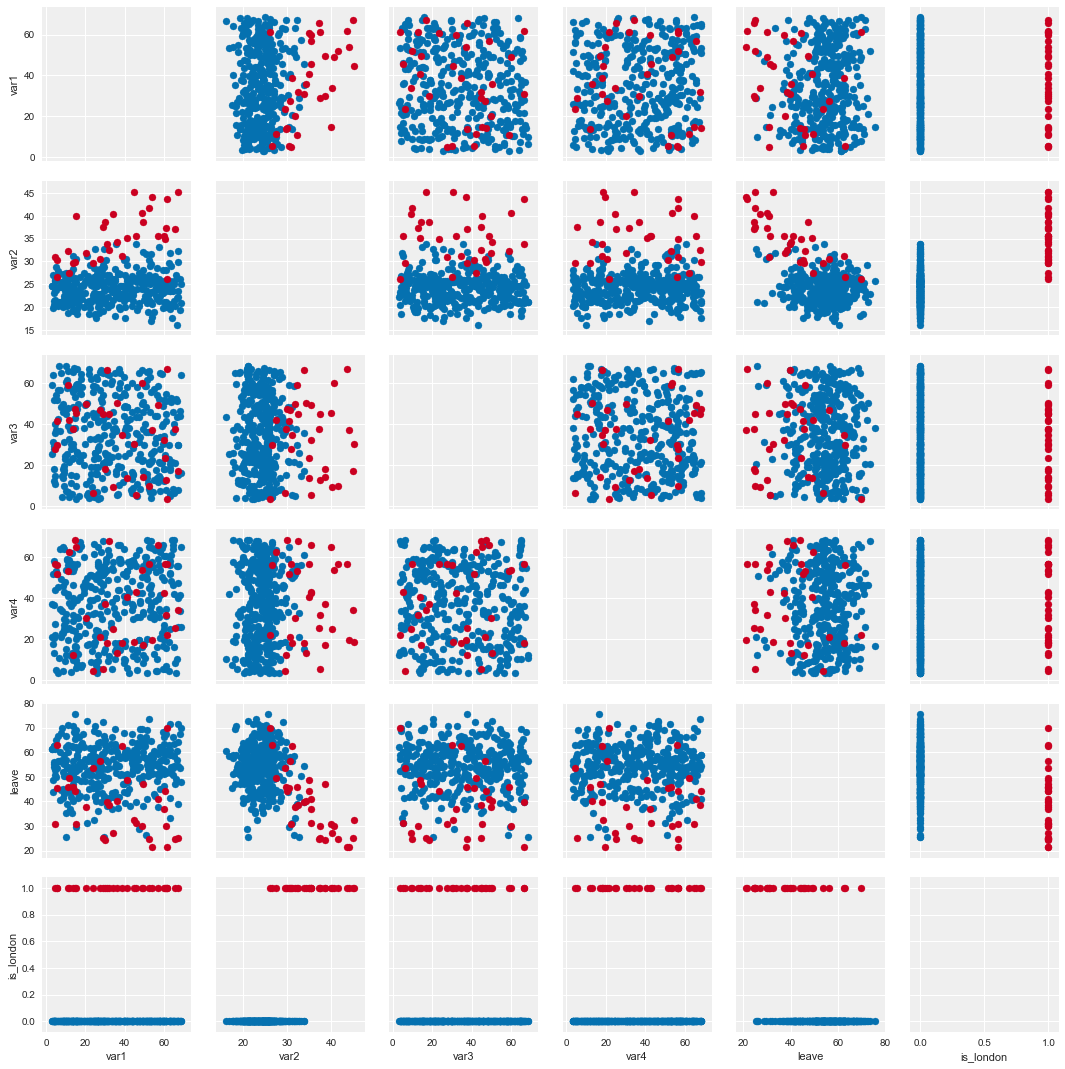

In [10]:
# Just adding the first four variables, plus leave, to start with—you'll see why
columns = [
    'var1',
    'var2',
    'var3',
    'var4',
    'leave',
    'is_london'
]

g = sns.PairGrid(
    data=df[columns],
    hue='is_london',
    palette=['#0571b0', '#ca0020']
)

g.map_offdiag(plt.scatter);

Try passing the remaining variables (`var5`-`var9`) to the pair grid. You should be able to see which of the variables in the dataset correlate most strongly with ‘leave’ vote percentage and whether the correlations are positive or negative.

## 4. Go into detail

Seaborn also provides a [`heatmap`](http://seaborn.pydata.org/generated/seaborn.heatmap.html) method that we can use to quickly compare the [correlation coefficient](http://www.investopedia.com/terms/c/correlationcoefficient.asp) of each pair of variables (the value between -1 and 1 that describes the strength of the relationship between them). We can pass all the columns we're interested in to the heatmap in one go, because heatmaps are easier to read than pair grids:

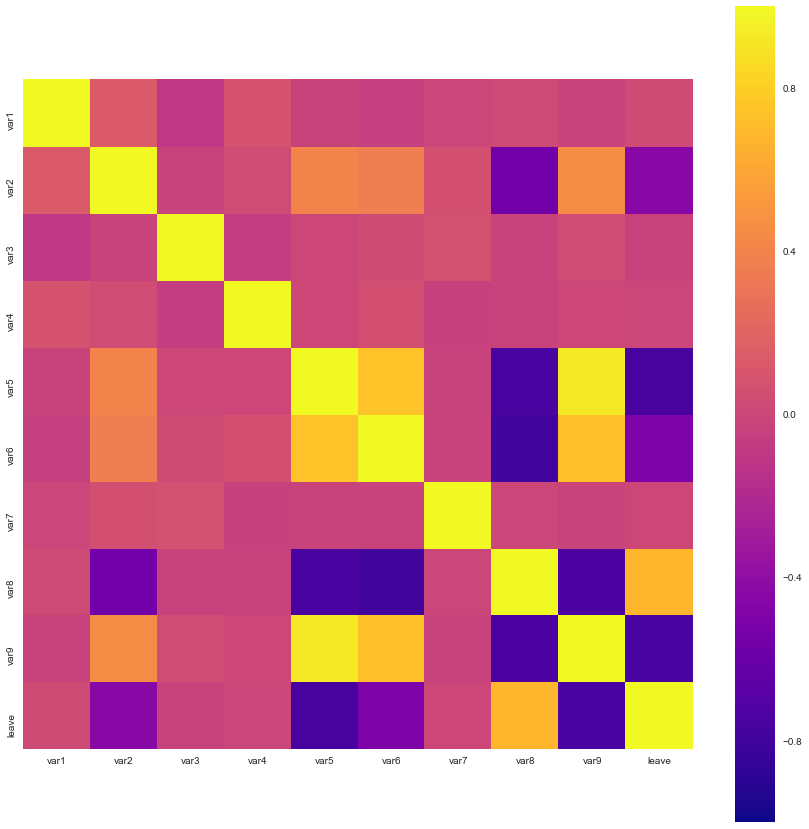

In [11]:
plt.figure(
    figsize=(15, 15),
    dpi=72
)

columns = [ # ALL THE COLUMNS
    'var1',
    'var2',
    'var3',
    'var4',
    'var5',
    'var6',
    'var7',
    'var8',
    'var9',
    'leave'
]

# Calculate the standard correlation coefficent of each pair of columns
correlations = df[columns].corr(method='pearson')

sns.heatmap(
    data=correlations,
    square=True,
    xticklabels=correlations.columns.values,
    yticklabels=correlations.columns.values,
    # The Matplotlib colormap to use
    # (https://matplotlib.org/examples/color/colormaps_reference.html)
    cmap='plasma'
)

By now, you should have a pretty good idea which variables are worth reporting as being significant demographic factors in the ‘leave’ vote. If you wanted to take your analysis even further, you could also report on whether London boroughs returned higher or lower ‘leave’ vote percentages than we would expect based on the values of any correlating variable. A convenient way to do this would be to use Seaborn's built-in [linear regression](https://seaborn.pydata.org/tutorial/regression.html) plotting:

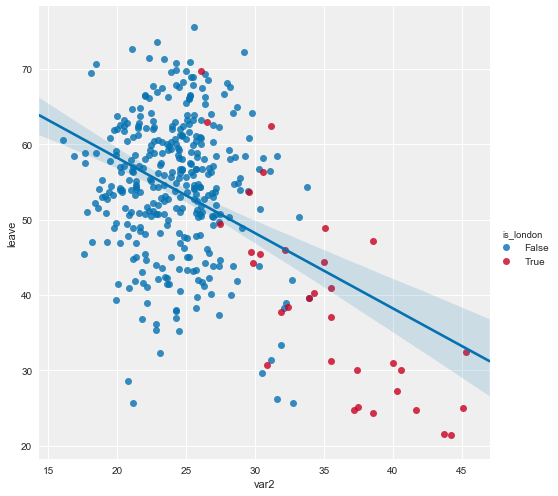

In [12]:
columns = ['var2', 'leave']

g = sns.lmplot(
    data=df,
    x=columns[0],
    y=columns[1],
    hue='is_london',
    palette=['#0571b0', '#ca0020'],
    size=7,
    fit_reg=False,
)

sns.regplot(
    data=df,
    x=columns[0],
    y=columns[1],
    scatter=False,
    color='#0571b0',
    ax=g.axes[0, 0]
)

Reading this plot, we're able to say that, all things being equal, most of the London boroughs have lower ‘leave’ vote percentages than we would expect based on their levels of `var2` alone. This suggests—rightly—that variables other than `var2` are in play in determining London's lower-than-expected levels of ‘leave’ voting.

## 5. Make a graphic and get it out of the notebook

Everyone knows that data journalism without pretty graphics is just _boring_. While the Matplotlib and Seaborn scatter plots get the job done, they're not exactly 😍 For that, we need Bokeh.

You can pretty much throw a stone and hit a data visualisation library these days, but Bokeh is a good fit for Jupyter notebooks because it's made for Python and can work with dataframes and all that other good stuff we've got going on in here. So let's fire it up by telling it that, like Matplotlib, we want it to plot in the notebook:

In [13]:
output_notebook()

Loading BokehJS ...

Because we want this to be our output graphic, we're going to be much fussier about how it looks, so there's quite a bit of configuration involved here:

In [14]:
color_map = {False: '#0571b0', True: '#ca0020'}

# Instantiate our plot
p = figure(
    plot_width=600,
    plot_height=422,
    background_fill_color='#d3d3d3',
    title='Leave demographics'
)

# Add a circle renderer to the plot
p.circle(
    x=df['var5'],
    y=df['leave'],
    # Size the markers according to the size of the electorate (scaled down)
    size=df['electorate'] / 20000,
    fill_color=df['is_london'].map(color_map),
    line_color=df['is_london'].map(color_map),
    line_width=1,
    alpha=0.5
)

# Configure the plot's x axis
p.xaxis.axis_label = 'var5'
p.xgrid.grid_line_color = None

# Configure the plot's y axis
p.yaxis.axis_label = 'Percentage voting leave'
p.ygrid.grid_line_color = '#999999'
p.ygrid.grid_line_alpha = 1
p.ygrid.grid_line_dash = [6, 4]

# Show the plot
show(p)

Now that's starting to look like something we could publish. Refer to the [Bokeh docs](http://bokeh.pydata.org/en/latest/docs/user_guide.html) for more customisation options, and when you're happy with how your plot looks, click the ‘Save’ button on the toolbar at the right of the plot to save it to disk as a PNG image. **If you want to, paste it into the [hackpad](https://journocoders.hackpad.com/Journocoders-April-2017-BLRJmLthZLk) with your name—coolest-looking one wins a drink!**

## 4. Baller-level challenges
* Using only pandas, identify the top five ‘leave’-voting areas in the country, both by vote percentage and per capita of the electorate
* Using [Jupyter interactors](http://bokeh.pydata.org/en/latest/docs/user_guide/notebook.html#jupyter-interactors), add a checkbox that toggles highlighting of London boroughs in your Bokeh plot
* Recreate your Bokeh plot in D3 (in the notebook). [Hint](https://github.com/PyGoogle/PyD3)